# Customer Churn Prediction (XGBoost) on Databricks

In this notebook we will:
1. Load engineered features from a Unity Catalog table
2. Train an XGBoost churn model and track everything with MLflow
3. Optimize the decision threshold for F1 score
4. Explain predictions using SHAP
5. Register the model to Unity Catalog Model Registry and assign an alias
6. Load the registered model and run inference
7. Evaluate with a confusion matrix


In [0]:
%pip install -q xgboost shap
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


## 1) Imports and MLflow setup

We import the Python libraries we need and configure the MLflow experiment location.


In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier

import mlflow
import mlflow.xgboost

EXPERIMENT_NAME = "/Shared/Customer_Churn_Prediction_XGBoost"
mlflow.set_experiment(EXPERIMENT_NAME)


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/2455449508799593', creation_time=1765876995605, experiment_id='2455449508799593', last_update_time=1765881096289, lifecycle_stage='active', name='/Shared/Customer_Churn_Prediction_XGBoost', tags={'mlflow.experiment.sourceName': '/Shared/Customer_Churn_Prediction_XGBoost',
 'mlflow.experimentKind': 'custom_model_development',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'georgian.pirvu@adastragrpde.onmicrosoft.com',
 'mlflow.ownerId': '141945821119864'}>

## 2) Load the feature table from Unity Catalog

We load the engineered feature table (a Delta table in Unity Catalog) and convert it to Pandas.
We use Pandas because scikit-learn / XGBoost training runs on a single driver node.


In [0]:
UC_TABLE_PATH = "churn_lab.gold.churn_features"  # update if your table is in a different schema
spark_df = spark.table(UC_TABLE_PATH)

print("Spark DataFrame Schema:")
spark_df.printSchema()

pdf = spark_df.toPandas()
print(f"\nData successfully loaded. Shape: {pdf.shape}")


Spark DataFrame Schema:
root
 |-- customer_id: string (nullable = false)
 |-- senior_citizen: integer (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- monthly_charges: double (nullable = true)
 |-- total_charges: double (nullable = true)
 |-- churn_label: integer (nullable = true)
 |-- partner_int: integer (nullable = true)
 |-- dependents_int: integer (nullable = true)
 |-- phone_service_int: integer (nullable = true)
 |-- multiple_lines_int: integer (nullable = true)
 |-- online_security_int: integer (nullable = true)
 |-- online_backup_int: integer (nullable = true)
 |-- device_protection_int: integer (nullable = true)
 |-- tech_support_int: integer (nullable = true)
 |-- streaming_tv_int: integer (nullable = true)
 |-- streaming_movies_int: integer (nullable = true)
 |-- paperless_billing_int: integer (nullable = true)
 |-- is_female: integer (nullable = true)
 |-- contract_month_to_month: integer (nullable = true)
 |-- contract_one_year: integer (nullable = true)
 |--

## 3) Define features (X), target (Y), and customer ID

We will:
- keep `customer_id` separately so we can attach it back to predictions later
- build X (features) and Y (label)


In [0]:
DROP_COLS = ["tenure_bucket", "churn_label", "customer_id"]
ID_COL = "customer_id"
TARGET_COL = "churn_label"

# Keep customer_id separately (so we can show it in inference results)
customer_ids = pdf[ID_COL].copy()

# Feature matrix and target vector
X = pdf.drop(columns=DROP_COLS)
Y = pdf[TARGET_COL].astype(int)  # ensure numeric 0/1

print(f"Features (X) Shape: {X.shape}")
print(f"Target (Y) Shape: {Y.shape}")


Features (X) Shape: (7032, 32)
Target (Y) Shape: (7032,)


## 4) Train/Test split (stratified)

We keep the churn rate similar in train and test by using `stratify=Y`.
We also split customer IDs in the same way so IDs match the rows of X_test.


In [0]:
churn_rate_original = Y.mean() * 100
print(f"Original Churn Rate: {churn_rate_original:.2f}%")

X_train, X_test, Y_train, Y_test, id_train, id_test = train_test_split(
    X, Y, customer_ids,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

print(f"Training Set Churn Rate: {Y_train.mean() * 100:.2f}%")
print(f"Test Set Churn Rate:     {Y_test.mean() * 100:.2f}%")

Original Churn Rate: 26.58%
Training Set Churn Rate: 26.58%
Test Set Churn Rate:     26.58%


## 5) Train baseline XGBoost model with MLflow tracking

We:
- start one MLflow run
- enable XGBoost autologging (parameters + model + artifacts)
- train a baseline model
- compute test metrics and log them

Note:
We compute and log important test metrics manually so we can compare them directly to AutoML results.


In [0]:
with mlflow.start_run(run_name="XGBoost_Baseline_Training") as run:
    run_id = run.info.run_id

    # Autolog XGBoost training details
    mlflow.xgboost.autolog(disable=False)

    # Optional: handle class imbalance (usually helps churn)
    neg = int((Y_train == 0).sum())
    pos = int((Y_train == 1).sum())
    scale_pos_weight = neg / pos

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "n_estimators": 200,
        "learning_rate": 0.05,
        "max_depth": 5,
        "random_state": 42,
        "scale_pos_weight": scale_pos_weight
    }

    xgb_model = XGBClassifier(**params)  # removed enable_categorical=True (not needed for numeric features)

    print("Starting model training...")
    xgb_model.fit(X_train, Y_train)
    print("Training complete.")

    # Predict churn probabilities for the test set
    y_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Metrics at default 0.5 threshold
    Y_pred_default = (y_proba > 0.5).astype(int)
    roc_auc = roc_auc_score(Y_test, y_proba)
    f1_default = f1_score(Y_test, Y_pred_default, zero_division=0)

    # Log key test metrics
    mlflow.log_metric("test_roc_auc", float(roc_auc))
    mlflow.log_metric("test_f1_default", float(f1_default))

    print(f"\nRun ID: {run_id}")
    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test F1 (threshold=0.5): {f1_default:.4f}")


2025/12/16 10:52:44 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.1.2. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.


Starting model training...


2025/12/16 10:52:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/16 10:52:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/local_disk0/.ephemeral_nfs/envs/pythonEnv-cb1a95f

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Training complete.


2025/12/16 10:52:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."



Run ID: c6c21025bfec4b31a83d5577fd40af96
Test ROC AUC: 0.8212
Test F1 (threshold=0.5): 0.6047


## 6) Threshold optimization (maximize F1)

A churn model outputs probabilities.
We convert probabilities to 0/1 using a threshold.

Here we search for the threshold that gives the best F1 score on the test set.
(This is fine for a lab demo. In a production pipeline, you usually optimize on a validation set.)


### Why Do We Need Threshold Optimization?

A classification model like XGBoost outputs **probabilities** (values between 0 and 1), not direct yes/no predictions.

To convert probabilities into binary predictions (0 = No Churn, 1 = Churn), we need a **decision threshold**:
- If `probability > threshold` → predict **Churn (1)**
- If `probability ≤ threshold` → predict **No Churn (0)**

By default, most models use a threshold of **0.5**, but this is often not optimal for business problems like churn prediction.

---

### What Does This Code Do?

This section searches for the **optimal threshold** that maximizes the **F1 score** on the test set.


In [0]:
thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = [f1_score(Y_test, (y_proba > t).astype(int), zero_division=0) for t in thresholds]

optimal_threshold_index = int(np.argmax(f1_scores))
optimal_threshold = float(thresholds[optimal_threshold_index])

Y_pred_optimized = (y_proba > optimal_threshold).astype(int)

p_opt = precision_score(Y_test, Y_pred_optimized, zero_division=0)
r_opt = recall_score(Y_test, Y_pred_optimized, zero_division=0)
f1_opt = float(f1_scores[optimal_threshold_index])

print(f"Optimal Threshold (T*): {optimal_threshold:.3f}")
print(f"Optimized Precision:    {p_opt:.4f}")
print(f"Optimized Recall:       {r_opt:.4f}")
print(f"Optimized F1:           {f1_opt:.4f}")

# Log optimized metrics to the SAME run (we are still in the active MLflow run context above)
with mlflow.start_run(run_id=run_id):
    mlflow.log_param("optimal_threshold", optimal_threshold)
    mlflow.log_metric("test_precision_optimized", float(p_opt))
    mlflow.log_metric("test_recall_optimized", float(r_opt))
    mlflow.log_metric("test_f1_optimized", float(f1_opt))


Optimal Threshold (T*): 0.475
Optimized Precision:    0.5000
Optimized Recall:       0.7834
Optimized F1:           0.6104


## 7) Explainability with SHAP

SHAP helps us answer:
- which features matter most overall (global)
- why the model predicted churn for one customer (local)

We use a sample to keep the notebook fast.


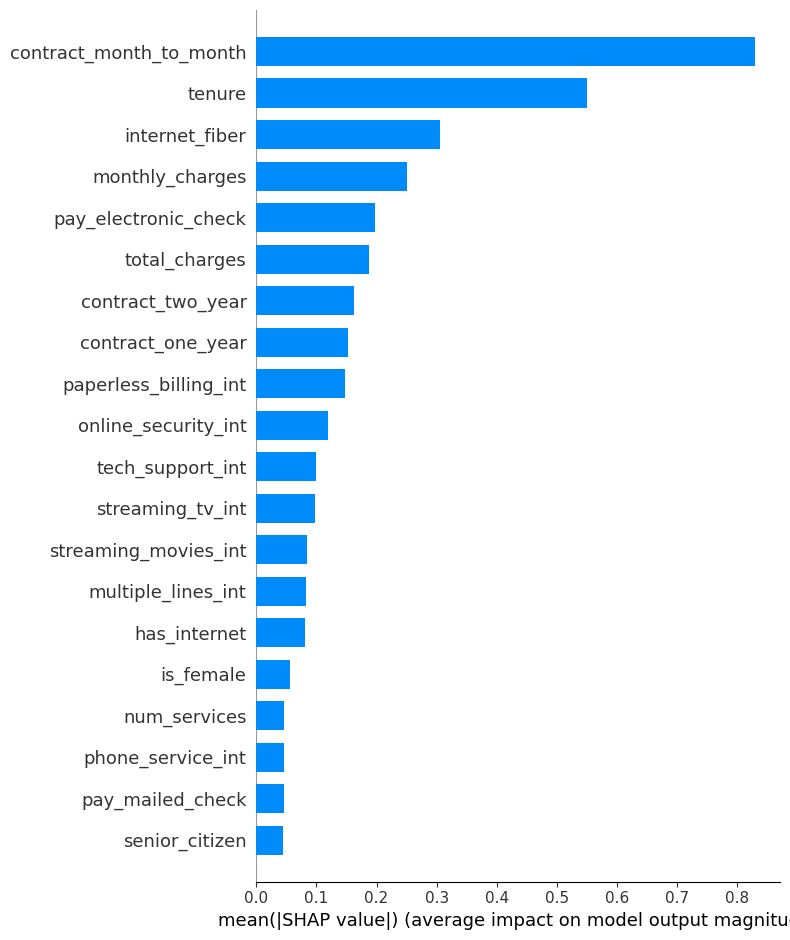

In [0]:
import shap
import matplotlib.pyplot as plt

X_sample = X_test.sample(n=min(500, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

# Global summary plot
shap.summary_plot(shap_values, X_sample, show=False)
plt.show()

# Global bar plot
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.show()


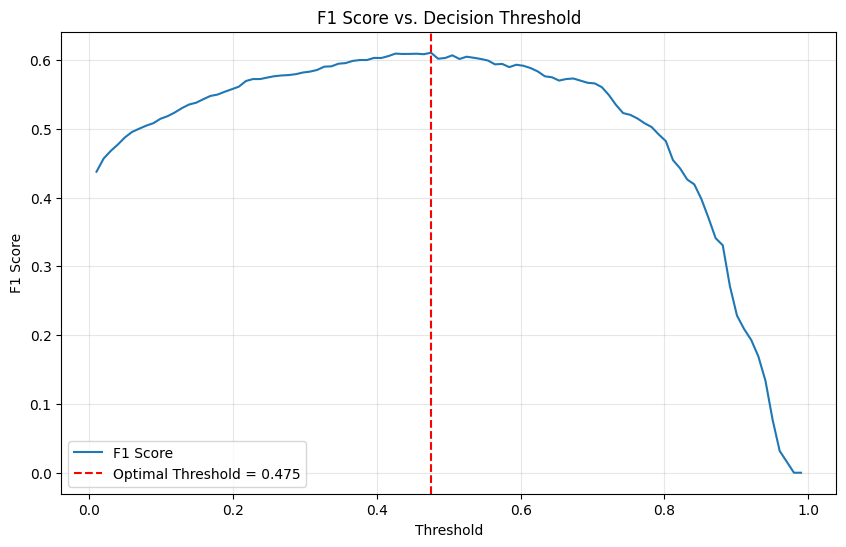

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Decision Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8) Register the model in Unity Catalog Model Registry and set an alias

We register the trained model under a 3-level name:
`catalog.schema.model_name`

Unity Catalog model registry uses ALIASES (not stages).
Common aliases: champion, candidate, baseline.
Note: "latest" is reserved and cannot be used.


In [0]:
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

UC_MODEL_NAME = "churn_lab.gold.xgboost_churn_predictor"
ALIAS_NAME = "champion"

# IMPORTANT: signature should match what predict() returns in serving.
# Here we will serve probabilities, so we sign X -> proba
signature = infer_signature(X_test, y_proba)

# End any active run before starting a new one for registration (optional but keeps things clean)
if mlflow.active_run() is not None:
    mlflow.end_run()

with mlflow.start_run(run_name="XGBoost_Model_Registration") as reg_run:
    model_info = mlflow.xgboost.log_model(
        xgb_model=xgb_model,
        artifact_path="xgboost_churn_model",
        signature=signature,
        input_example=X_test.head(5),
        registered_model_name=UC_MODEL_NAME,
        metadata={"optimal_threshold": str(optimal_threshold)},
    )
    reg_run_id = reg_run.info.run_id

client = MlflowClient()
model_version = getattr(model_info, "registered_model_version", None)

if model_version is None:
    versions = client.search_model_versions(f"name='{UC_MODEL_NAME}'")
    versions_for_run = [v for v in versions if v.run_id == reg_run_id]
    if not versions_for_run:
        raise RuntimeError(f"Could not find a model version for run_id={reg_run_id} and model={UC_MODEL_NAME}")
    model_version = str(max(int(v.version) for v in versions_for_run))

client.set_registered_model_alias(
    name=UC_MODEL_NAME,
    alias=ALIAS_NAME,
    version=model_version
)

print(f"Model registered in Unity Catalog as: {UC_MODEL_NAME}")
print(f"Registration Run ID: {reg_run_id}")
print(f"Alias '{ALIAS_NAME}' -> version {model_version}")
print(f"Load it with: models:/{UC_MODEL_NAME}@{ALIAS_NAME}")


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-cb1a95ff-182f-45e3-8a5a-472b3e04cb7d/lib/python3.12/site-packages/xgboost/sklearn.py:1116: UserWarning: [10:52:55] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as 

Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Registered model 'churn_lab.gold.xgboost_churn_predictor' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://stgadbdemosgeorge.dfs.core.windows.net/uccatalog/files%2Fd13da911-c897-4aaa-aaa0-7b48edc3e989%2Fmodels%2F590e2546-a886-4e61-ba7c-4cc0243c5966%2Fversions%2F77c7c77b-a250-404b-8873-c05cb6b218d0%2Fpython_env.yaml?resource=REDACTED&st=REDACTED&sv=REDACTED&ske=REDACTED&sig=REDACTED&sktid=REDACTED&se=REDACTED&sdd=REDACTED&skoid=REDACTED&spr=REDACTED&sks=REDACTED&skt=REDACTED&sp=REDACTED&skv=REDACTED&sr=REDACTED'
Request method: 'PUT'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/json'
    'User-Agent': 'azsdk-python-storage-dfs/12.17.0 Python/3.12.3 (Linux-6.6.104.2-4.azl3-x86_64-with-glibc2.39)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '637fc3a0-da6d-11f0-964c-2edf6a203a48'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://stgadbdemosgeorge.dfs.core.windows.net/uccatalog/files%2Fd13da911-c897-4aaa-aaa0-7b48edc

Model registered in Unity Catalog as: churn_lab.gold.xgboost_churn_predictor
Registration Run ID: e73e25fdf1474f2390a7e1c9c0f58350
Alias 'champion' -> version 8
Load it with: models:/churn_lab.gold.xgboost_churn_predictor@champion


## 9) Load the registered model and run inference

We load the model using:
`models:/catalog.schema.model@alias`

We also read the optimized threshold from model metadata.
Then we create business-friendly predictions (0/1).


In [0]:
import mlflow

MODEL_URI = f"models:/{UC_MODEL_NAME}@{ALIAS_NAME}"
print(f"Loading model from UC: {MODEL_URI}...")

loaded_model = mlflow.pyfunc.load_model(MODEL_URI)

# Retrieve threshold from metadata
model_metadata = loaded_model.metadata.metadata
loaded_threshold = float(model_metadata.get("optimal_threshold", 0.5))
print(f"Retrieved Optimal Threshold (T*): {loaded_threshold}")

# Predict probabilities
y_pred_proba_live = loaded_model.predict(X_test)

# If predict() returns a 2D array, keep positive class column
if isinstance(y_pred_proba_live, (np.ndarray, list)) and np.asarray(y_pred_proba_live).ndim == 2:
    y_pred_proba_live = np.asarray(y_pred_proba_live)[:, 1]

# Apply threshold
final_predictions = (np.asarray(y_pred_proba_live) > loaded_threshold).astype(int)

# Build results (customer_id is id_test, not X_test.index)
results_df = pd.DataFrame({
    "customer_id": id_test.values,
    "churn_probability": np.asarray(y_pred_proba_live),
    "churn_prediction_optimized": final_predictions
})

print("\nExample of Final Predictions (First 5 records):")
display(results_df.head())


Loading model from UC: models:/churn_lab.gold.xgboost_churn_predictor@champion...


INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://stgadbdemosgeorge.dfs.core.windows.net/uccatalog?resource=REDACTED&directory=REDACTED&recursive=REDACTED&st=REDACTED&sv=REDACTED&ske=REDACTED&sig=REDACTED&sktid=REDACTED&se=REDACTED&sdd=REDACTED&skoid=REDACTED&spr=REDACTED&sks=REDACTED&skt=REDACTED&sp=REDACTED&skv=REDACTED&sr=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/json'
    'User-Agent': 'azsdk-python-storage-dfs/12.17.0 Python/3.12.3 (Linux-6.6.104.2-4.azl3-x86_64-with-glibc2.39)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '6506c1c8-da6d-11f0-80a9-2edf6a203a48'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json;charset=utf-8'
    'Server': 'Windows-Azure-HDFS/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '05f9a6d9-b01f-0024-2f

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://stgadbdemosgeorge.dfs.core.windows.net/uccatalog?resource=REDACTED&directory=REDACTED&recursive=REDACTED&st=REDACTED&sv=REDACTED&ske=REDACTED&sig=REDACTED&sktid=REDACTED&se=REDACTED&sdd=REDACTED&skoid=REDACTED&spr=REDACTED&sks=REDACTED&skt=REDACTED&sp=REDACTED&skv=REDACTED&sr=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/json'
    'User-Agent': 'azsdk-python-storage-dfs/12.17.0 Python/3.12.3 (Linux-6.6.104.2-4.azl3-x86_64-with-glibc2.39)'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '6517a144-da6d-11f0-a004-2edf6a203a48'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://stgadbdemosgeorge.dfs.core.windows.net/uccatalog?resource=REDACTED&directory=REDACTED&recursive=REDACTED&st=REDACTED&sv=REDACTED&ske=REDACTED&sig=REDACTED&sktid=REDACTED&se=REDACTED&sdd=REDACTED&skoid=REDACTED&s

Retrieved Optimal Threshold (T*): 0.47525252525252526

Example of Final Predictions (First 5 records):


customer_id churn_probability churn_prediction_optimized 5600-PDUJF 1 1 7396-VJUZB 1 1 6556-DBKZF 0 0 1465-VINDH 1 1 5844-QVTAT 0 0

## 10) Compare predictions to actual churn

For evaluation, we join predictions with the ground-truth label (Y_test).
In production, the actual churn label is only known later.


In [0]:
evaluation_df = results_df.copy()
evaluation_df["actual_churn"] = Y_test.values

display(
    evaluation_df[["customer_id", "churn_probability", "actual_churn", "churn_prediction_optimized"]].head(5)
)


customer_id churn_probability actual_churn churn_prediction_optimized 5600-PDUJF 1 0 1 7396-VJUZB 1 0 1 6556-DBKZF 0 0 0 1465-VINDH 1 1 1 5844-QVTAT 0 0 0

## 11) Confusion matrix

The confusion matrix shows:
- True Negatives (TN): correctly predicted no churn
- False Positives (FP): predicted churn but actually no churn
- False Negatives (FN): missed churners
- True Positives (TP): correctly predicted churn

This is a great final visual for the lab.


INFO:py4j.clientserver:Received command c on object id p0


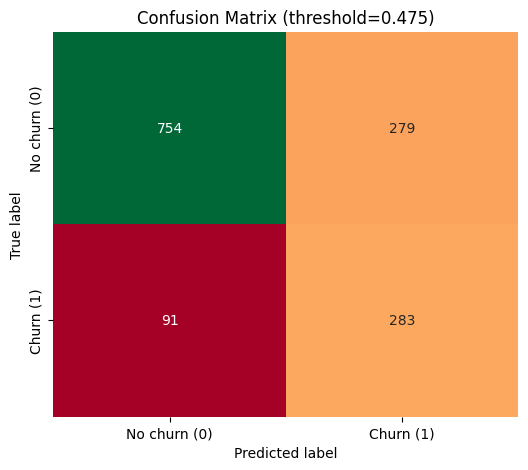

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, final_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn",   # red = bad, green = good
    cbar=False,
    xticklabels=["No churn (0)", "Churn (1)"],
    yticklabels=["No churn (0)", "Churn (1)"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix (threshold={loaded_threshold:.3f})")
plt.show()


## Confusion Matrix Interpretation (Threshold = 0.475)

This confusion matrix summarizes how the churn model performs on the **test dataset** when using the optimized decision threshold of **0.475**.

### Breakdown of Results

- **True Negatives (TN = 754)**  
  Customers who **did not churn** and were **correctly predicted as non-churners**.  
  → This is good performance: the model reliably identifies loyal customers.

- **False Positives (FP = 279)**  
  Customers who **did not churn** but were **predicted to churn**.  
  → These are *false alarms*. In a business context, this means offering retention incentives to customers who would have stayed anyway (potential extra cost, but usually acceptable in churn use cases).

- **False Negatives (FN = 91)**  
  Customers who **did churn** but were **predicted as non-churners**.  
  → These are the **most costly errors** in churn prediction, because the business misses the chance to intervene and prevent churn.

- **True Positives (TP = 283)**  
  Customers who **did churn** and were **correctly predicted as churners**.  
  → These are the high-value wins: customers correctly identified for proactive retention actions.

### What This Tells Us

- The model captures **most churners** (283 out of 374 actual churners), which explains the **strong recall**.
- The optimized threshold intentionally allows more **false positives** to reduce **false negatives** which is a common and *desirable* trade-off in churn prevention.
- Overall behavior is **business-aligned**:
  - Better to contact some customers unnecessarily  
  - Than to lose customers without any intervention

### Business Interpretation

With this model and threshold:
- Marketing or customer success teams can confidently target the **~560 customers predicted to churn**
- Roughly **1 out of 2 targeted customers actually churns**, which is strong for churn campaigns
- The model is suitable for **retention-focused strategies**, where recall is more important than precision

In short:  
**This is a realistic and healthy confusion matrix for a churn prediction use case.**


## Done

At this point you have:
- A trained churn model
- MLflow experiment tracking
- Threshold optimization for business decisions
- SHAP explainability
- A registered Unity Catalog model with a 'champion' alias
- Inference results + evaluation with a confusion matrix
